In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable
import sys
sys.path.append('../')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+d9edefe torch: 0.2.0+0989889 cuda: False


# Parameters

In [2]:
# model parameters
NUM_PIXELS = 784
NUM_HIDDEN = 256
NUM_DIGITS = 10
NUM_STYLE = 50   

# training parameters
NUM_SAMPLES = 8 
NUM_BATCH = 128
NUM_EPOCHS = 100
LABEL_FRACTION = 0.1
LEARNING_RATE = 1e-3
BETA1 = 0.90
EPS = 1e-9

# path parameters
MODEL_NAME = 'mnist-semisupervised-%02ddim' % NUM_STYLE
DATA_PATH = '../data'
WEIGHTS_PATH = '../weights'
RESTORE = False

# Encoder Model

In [10]:
from functools import wraps
def expand_inputs(f):
    @wraps(f)
    def g(*args, num_samples=None, **kwargs):
        if not num_samples is None:
            new_args = []
            new_kwargs = {}
            for arg in args:
                if hasattr(arg, 'expand'):
                    new_args.append(arg.expand(num_samples, *arg.size()))
                else:
                    new_args.append(arg)
            for k in kwargs:
                arg = kwargs[k]
                if hasattr(arg, 'expand'):
                    new_args.append(arg.expand(num_samples, *arg.size()))
                else:
                    new_args.append(arg)
            return f(*new_args, num_samples=num_samples, **new_kwargs)
        else:
            return f(*args, num_samples=None, **kwargs)
    return g
        
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_digits=NUM_DIGITS,
                       num_style=NUM_STYLE,
                       num_batch=NUM_BATCH):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential( 
                            nn.Linear(num_pixels, num_hidden),
                            nn.ReLU())
        self.digit_log_weights = nn.Linear(num_hidden, num_digits)
        self.digit_temp = 0.66
        self.style_mean = nn.Linear(num_hidden + num_digits, num_style)
        self.style_log_std = nn.Linear(num_hidden + num_digits, num_style)
    
    @expand_inputs
    def forward(self, images, labels=None, num_samples=None):
        q = probtorch.Trace()
        hiddens = self.enc_hidden(images)
        digits = q.concrete(self.digit_log_weights(hiddens),
                            self.digit_temp,
                            value=labels,
                            name='digits')
        hiddens2 = torch.cat([digits, hiddens], -1)
        styles_mean = self.style_mean(hiddens2)
        styles_std = torch.exp(self.style_log_std(hiddens2))
        q.normal(styles_mean,
                 styles_std,
                 name='styles')
        return q

# Decoder Model

In [11]:
class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_digits=NUM_DIGITS,
                       num_style=NUM_STYLE):
        super(self.__class__, self).__init__()
        self.digit_log_weights = Variable(torch.zeros(num_digits))
        self.digit_temp = 0.66
        self.style_mean = Variable(torch.zeros(num_style))
        self.style_log_std = Variable(torch.zeros(num_style))
        self.dec_hidden = nn.Sequential(
                            nn.Linear(num_style + num_digits, num_hidden),
                            nn.ReLU())
        self.dec_image = nn.Sequential(
                           nn.Linear(num_hidden, num_pixels),
                           nn.Sigmoid())

    def forward(self, images, q=None, num_samples=None):
        p = probtorch.Trace()
        digits = p.concrete(self.digit_log_weights,
                            self.digit_temp,
                            value=q['digits'],
                            name='digits')
        styles = p.normal(self.style_mean,
                          torch.exp(self.style_log_std),
                          value=q['styles'],
                          name='styles')
        hiddens = self.dec_hidden(torch.cat([digits, styles], -1))
        images_mean = self.dec_image(hiddens)
        p.loss(lambda x_hat, x: -(torch.log(x_hat + EPS) * x + 
                                  torch.log(1 - x_hat + EPS) * (1-x)).sum(-1),
               images_mean, images, name='images')
        return p

# Loss

In [12]:
def elbo(q, p, alpha=0.1):
    if NUM_SAMPLES is None:
        return probtorch.objectives.importance.elbo(q, p, alpha, sample_dim=None, batch_dim=0)
    else:
        return probtorch.objectives.importance.elbo(q, p, alpha, sample_dim=0, batch_dim=1)

# Data

In [13]:
from torchvision import datasets, transforms
import os 

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 
test_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=False, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 

# Training and Testing

In [14]:
enc = Encoder()
dec = Decoder()
optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                              lr=LEARNING_RATE,
                              betas=(BETA1, 0.999))

In [15]:
def train(data, enc, dec, optimizer, 
          label_mask={}, label_fraction=LABEL_FRACTION):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = Variable(images).view(-1, NUM_PIXELS)
            labels_onehot = torch.zeros(NUM_BATCH, NUM_DIGITS)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
            labels_onehot = Variable(torch.clamp(labels_onehot, EPS, 1-EPS))
            optimizer.zero_grad()
            if b not in label_mask:
                label_mask[b] = (random() < label_fraction)
            if label_mask[b]:
                q = enc(images, labels_onehot, num_samples=NUM_SAMPLES)
            else:
                q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            loss = -elbo(q, p)
            loss.backward()
            optimizer.step()
            epoch_elbo -= loss.data.numpy()[0]
    return epoch_elbo / N, label_mask

def test(data, enc, dec, infer=True):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    epoch_correct = 0
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = Variable(images).view(-1, NUM_PIXELS)
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            epoch_elbo += elbo(q, p).data.numpy()[0]
            if infer:
                log_W = probtorch.objectives.log_joint(p, 0, 1) - probtorch.objectives.log_joint(q, 0, 1)
                log_Z = probtorch.util.log_sum_exp(log_W, 0)
                W = torch.exp(log_W - log_Z)
                y_samples = q['digits'].value
                y_expect = (W.unsqueeze(-1) * y_samples).sum(0)
                _ , y_pred = y_expect.data.max(-1)
                epoch_correct += (labels == y_pred).sum()
            else:
                _, y_pred = q['digits'].value.data.max(-1)
                epoch_correct += (labels == y_pred).sum()*1.0 / (NUM_SAMPLES or 1.0)
    return epoch_elbo / N, epoch_correct / N

In [16]:
import time
from random import random
if not RESTORE:
    mask = {}
    for e in range(NUM_EPOCHS):
        train_start = time.time()
        train_elbo, mask = train(train_data, enc, dec, 
                                 optimizer, mask, LABEL_FRACTION)
        train_end = time.time()
        test_start = time.time()
        test_elbo, test_accuracy = test(test_data, enc, dec)
        test_end = time.time()
        print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e, Accuracy %0.3f (%ds)' % (
                e, train_elbo, train_end - train_start, 
                test_elbo, test_accuracy, test_end - test_start))

    if not os.path.isdir(WEIGHTS_PATH):
        os.mkdir(WEIGHTS_PATH)
    torch.save(enc.state_dict(),
               '%s/%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME))
    torch.save(dec.state_dict(),
               '%s/%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME))

[Epoch 0] Train: ELBO -1.3277e+00 (60s) Test: ELBO -1.0693e+00, Accuracy 0.099 (5s)
[Epoch 1] Train: ELBO -1.0198e+00 (59s) Test: ELBO -9.6750e-01, Accuracy 0.101 (4s)
[Epoch 2] Train: ELBO -9.4556e-01 (57s) Test: ELBO -9.0872e-01, Accuracy 0.225 (4s)
[Epoch 3] Train: ELBO -8.9885e-01 (56s) Test: ELBO -8.7392e-01, Accuracy 0.471 (4s)
[Epoch 4] Train: ELBO -8.7059e-01 (56s) Test: ELBO -8.5264e-01, Accuracy 0.535 (4s)
[Epoch 5] Train: ELBO -8.5268e-01 (56s) Test: ELBO -8.3771e-01, Accuracy 0.603 (4s)
[Epoch 6] Train: ELBO -8.3941e-01 (56s) Test: ELBO -8.2613e-01, Accuracy 0.738 (4s)
[Epoch 7] Train: ELBO -8.2991e-01 (56s) Test: ELBO -8.1909e-01, Accuracy 0.786 (4s)
[Epoch 8] Train: ELBO -8.2198e-01 (56s) Test: ELBO -8.1307e-01, Accuracy 0.803 (4s)
[Epoch 9] Train: ELBO -8.1583e-01 (56s) Test: ELBO -8.0757e-01, Accuracy 0.824 (4s)
[Epoch 10] Train: ELBO -8.1052e-01 (55s) Test: ELBO -8.0231e-01, Accuracy 0.839 (4s)
[Epoch 11] Train: ELBO -8.0607e-01 (55s) Test: ELBO -7.9843e-01, Accuracy 0

[Epoch 97] Train: ELBO -7.5519e-01 (64s) Test: ELBO -7.5474e-01, Accuracy 0.939 (3s)
[Epoch 98] Train: ELBO -7.5521e-01 (63s) Test: ELBO -7.5490e-01, Accuracy 0.938 (4s)
[Epoch 99] Train: ELBO -7.5519e-01 (64s) Test: ELBO -7.5492e-01, Accuracy 0.943 (4s)


In [34]:
_, test_accuracy_no_infer = test(test_data, enc, dec, infer=False)
_, test_accuracy_infer = test(test_data, enc, dec, infer=True)

In [35]:
test_accuracy_infer,test_accuracy_no_infer

(0.9437099358974359, 0.9273462540064102)

In [28]:
if RESTORE:
    enc.load_state_dict(torch.load('%s/%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME)))
    dec.load_state_dict(torch.load('%s/%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME)))

# Visualize Embeddings

In [17]:
import numpy as np
ys = []
zs = []
for (x, y) in test_data:
    if len(x) == NUM_BATCH:
        images = Variable(x).view(-1, NUM_PIXELS)
        q = enc(images)
        zs.append(q['styles'].value.data.numpy())
        ys.append(y.numpy())
ys = np.concatenate(ys,0)
zs = np.concatenate(zs,0)

In [18]:
# run TSNE when number of latent dims exceeds 2
if NUM_STYLE > 2:
    from sklearn.manifold import TSNE
    zs2 = TSNE().fit_transform(zs)
    zs2_mean = zs2.mean(0)
    zs2_std = zs2.std(0)
else:
    zs2 = zs

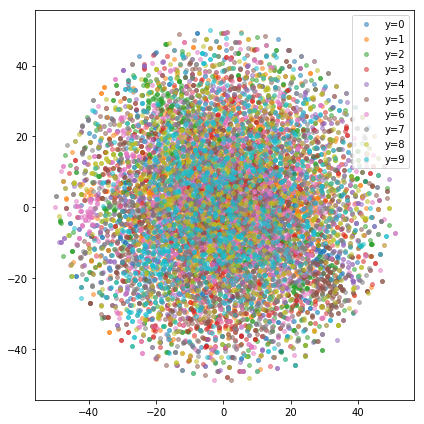

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

colors = []
for k in range(10):
    m = (ys == k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%d' % k, alpha=0.5, s=15)
    colors.append(p.get_facecolor())
ax.legend()

fig.tight_layout()
#fig.savefig('images/%s-%02d-encodings.png' % (MODEL_NAME, NUM_STYLE), dpi=300)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

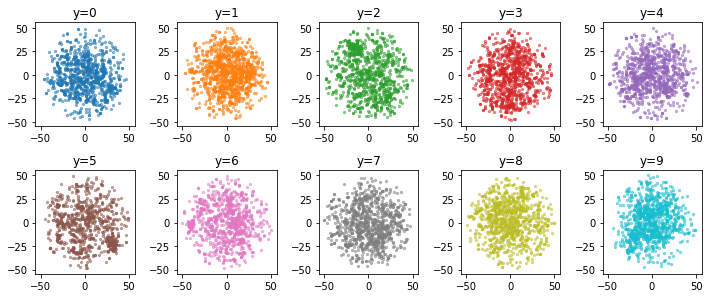

In [27]:
# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(10,4.25))

for k in range(10):
    ax = plt.subplot(2,5,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()

# Visualize Reconstructed Digits

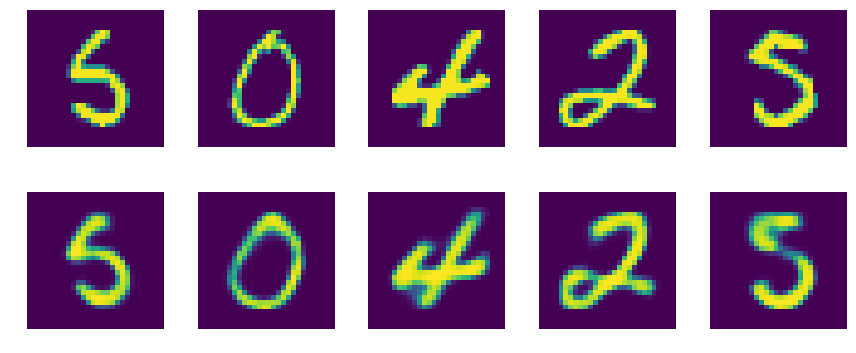

In [25]:
x,_ = next(iter(train_data))
x_var = Variable(x.view(-1, NUM_PIXELS))
q = enc(x_var)
p = dec(x_var, q)
x_mean = p['images'].value.view(NUM_BATCH, 28, 28)

fig = plt.figure(figsize=(12,5.25))
for k in range(5):
    ax = plt.subplot(2, 5, k+1)
    ax.imshow(x[k].numpy().squeeze())
    #ax.set_title("original")
    plt.axis("off")
    ax = plt.subplot(2, 5, k+6)
    ax.imshow(x_mean[k].data.numpy().squeeze())
    #ax.set_title("reconstructed")
    plt.axis("off")
    
fig.tight_layout()
#fig.savefig('images/%s-%02d-reconstructions-separate.png' % (MODEL_NAME, NUM_STYLE), dpi=300, facecolor=[0,0,0,0])

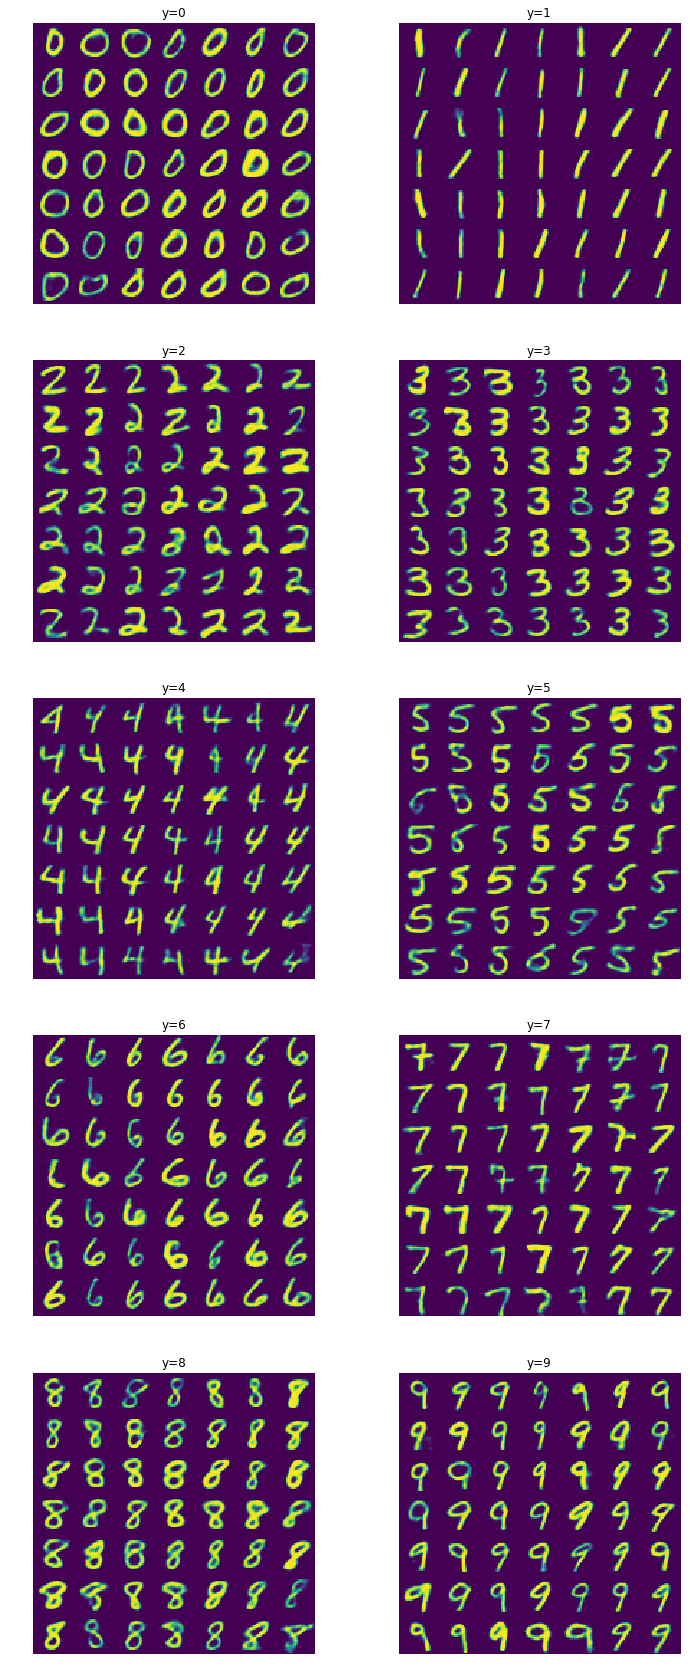

In [28]:
# display a 2D manifold of the digits
n = 7  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
null_image = Variable(torch.Tensor(np.zeros((1, 784))))

plt.figure(figsize=(12, 30))
for y in range(10):
    plt.subplot(5, 2, y+1)
    y_hot = np.zeros((1,10))
    y_hot[0,y] = 1
    y_hot = Variable(torch.FloatTensor(y_hot))
    my = (ys == y)
    for i, z0i in enumerate(grid_x):
        for j, z1j in enumerate(grid_y[-1::-1]):
            z = np.array([[z0i, z1j]])
            if NUM_STYLE > 2:
                z = zs2_mean[None,:] + zs2_std[None,:] * z
                n = ((zs2[my] - z)**2).sum(1).argmin()
                z = zs[my][n][None,:]
            z = Variable(torch.FloatTensor(z))
            p = dec(null_image, {'styles': z, 'digits': y_hot})
            digit = p['images'].value.data.numpy().reshape(digit_size, digit_size)
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = digit
    plt.imshow(figure)
    plt.title('y=%d' % y)
    plt.axis('off')
plt.show()